# Análisis de series de tiempo por cada parámetro

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import numpy as np
import warnings
warnings.filterwarnings("ignore")

Se toman las mejores estaciones según el análisis de Sara, y valores entre las 6AM y 9PM

In [2]:
#location = pd.read_excel("Data/cat.xlsx")
meteo = pd.read_csv("Data/meteorologyAll.csv")[['dateUTCShiftedDown', 'original',
                                                'id_parameter_id', 'id_station_id']]
poll = pd.read_csv("Data/pollutantsAll.csv")[['dateUTCShiftedDown', 'original',
                                                'id_parameter_id', 'id_station_id']]
meteo["dateUTCShiftedDown"] = pd.to_datetime(meteo["dateUTCShiftedDown"])
poll["dateUTCShiftedDown"] = pd.to_datetime(poll["dateUTCShiftedDown"])

#st = ['VIF', 'TAH', 'XAL', 'MGH', 'UAX', 'UIZ', 'TLA', 'AJM', 'SAC', 'BJU', 'SFE', 'CUT', 'CUA', 'MON', 'FAC', 'SAG', 'PED', 'NEZ', 'MER',
#      'HGM', 'SUR', 'TPN']

#st_20 = ["PED", "SFE", "UIZ", "CAM", "TLA", "MER", "SAG", "FAC", "VIF", "NEZ"]
st_19 = ["MER", "AJM", "PED", "SFE", "XAL", "HGM", "TLA", "FAC", "VIF", "MGH", "TAH", "MON", "CUA", "CUT", "UIZ", "NEZ", "UAX", "GAM", "SAG",
         "BJU", "MPA", "ACO", "SAC", "CCA", "INN", "CHO", "TLI", "LLA", "ATI", "CAM", "FAR"]
#st_18 = ["MER", "AJM", "PED", "SFE", "XAL", "HGM", "TLA", "FAC", "VIF", "MGH", "TAH", "MON", "CUA", "CUT", "UIZ", "NEZ", "UAX", "GAM", "SAG",
#         "BJU", "MPA", "ACO", "IZT", "CCA", "INN", "CHO", "TLI", "LLA", "ATI", "CAM", "LAA"]

meteo = meteo[(meteo["dateUTCShiftedDown"].dt.hour<22)&(meteo["dateUTCShiftedDown"].dt.hour>5)&(meteo["id_station_id"].isin(st_19))].dropna()
poll = poll[(poll["dateUTCShiftedDown"].dt.hour<22)&(poll["dateUTCShiftedDown"].dt.hour>5)&(poll["id_station_id"].isin(st_19))].dropna()

### Función para normalizar los datos

In [3]:
def normalize(df,param,r,c):
    fig, axs = plt.subplots(r, c, figsize=(20,5))
    
    for i in range(r):
        for j in range(c):
            data = np.array(df[df["id_parameter_id"] == param[i][j]]["original"])
            data = (data-data.min())/ (data.max() - data.min())
            axs[i, j].hist(data, 100, density=True)
            axs[i, j].set_title(param[i][j])
    
    plt.tight_layout()
    plt.show() 

En general se observa un sesgo a la derecha de cada uno de los parámetros a excepción de `RH` y `TMP`

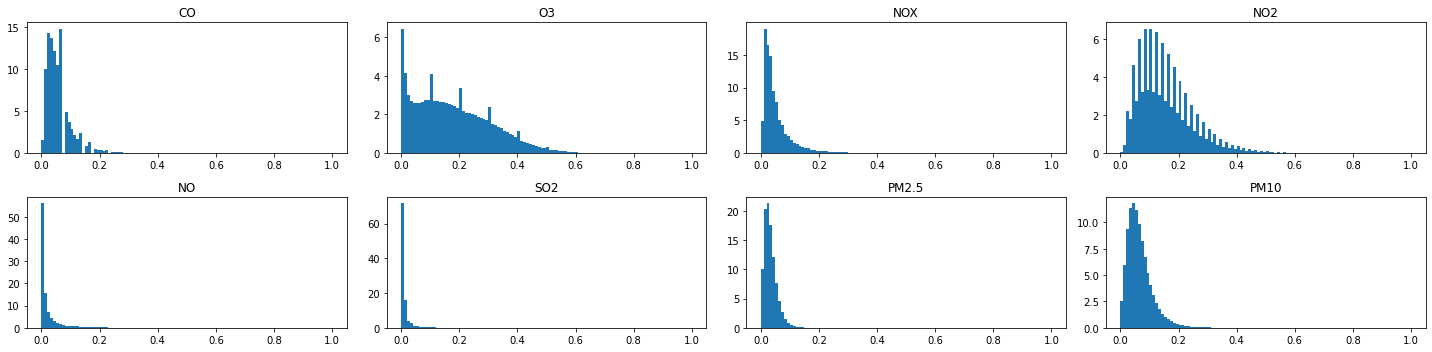

In [4]:
normalize(poll,[["CO","O3","NOX","NO2"],["NO","SO2","PM2.5","PM10"]],2,4)

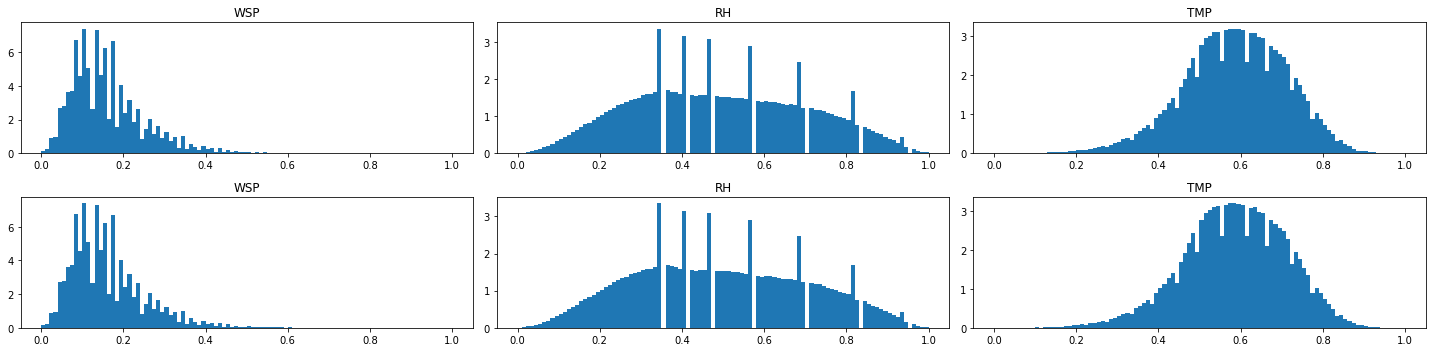

In [5]:
normalize(meteo,[["WSP","RH","TMP"],["WSP","RH","TMP"]],2,3)

Función para extraer el parámetro por hora y función para extraer la mediana por días de los parámetros

In [3]:
def param(bs,parameter):
    return bs[bs["id_parameter_id"] == parameter]
def paramD(bs,parameter):
    return param(bs,parameter).groupby(by=[pd.Grouper(key="dateUTCShiftedDown",freq = "D")])["original"].median().to_frame().reset_index().dropna()

# Serie de tiempo

Toda serie de tiempo está descrita por la siguiente ecuación

$$Y_t = \alpha Y_{t-1} + \beta Y_e +\epsilon$$

Donde el primer término nos dice que el valor acutal está descrito por el valor anterior mas el segundo término $Y_e$ el cuál corresponde a una variable exógena

## Estacionariedad

Se realiza el test Dickey-Fuller para saaber si la serie de tiempo es estacionaria 

### PM10

Se observa que por horas el valor que mejor describe el valor actual es el de hace una hora y el de hace 15 horas (o el de hace 1 día ya que se tomaron valores de 6AM y 9PM). Y para valores promediados por día, el valor que mejor describe el valor actual es de hace un día y el de hace 365 días o hace un años, además de una autocorrelación negativa a mediados de año (correlación que se observó en `analysis3.ipynb`)

In [6]:
pm10 = param(poll,"PM10")
pm10D = paramD(poll,"PM10")

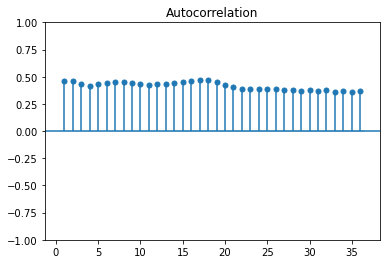

In [6]:
sgt.plot_acf(pm10["original"],lags=36,zero=False);

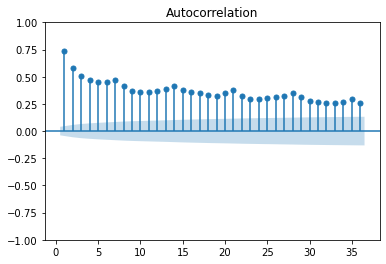

In [7]:
sgt.plot_acf(pm10D["original"],lags=36,zero=False);

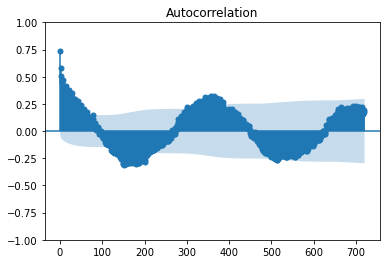

In [8]:
sgt.plot_acf(pm10D["original"],lags=720,zero=False);

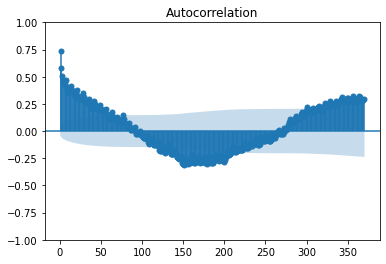

In [9]:
sgt.plot_acf(pm10D["original"],lags=370,zero=False);

In [10]:
result = sts.adfuller(pm10["original"],regression="ct",maxlag=16,autolag=None)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -47.29396394930734
p-value: 0.0
Critial Values:
   1%, -3.958784381599791
Critial Values:
   5%, -3.410496974502346
Critial Values:
   10%, -3.1270541074293448


In [11]:
result = sts.adfuller(pm10D["original"],regression="ct",maxlag=365,autolag=None)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.8230339265602131
p-value: 0.6935470085748467
Critial Values:
   1%, -3.963046669473269
Critial Values:
   5%, -3.412562958660295
Critial Values:
   10%, -3.128270498299351


Este tiene por hipótesis nula que la serie no es estacionaria con un nivel de confianza p > 0.05, en este caso no hay necesidad de refutarla y por lo tanto nuestra serie de tiempo promediada por día es **no-estacionaria**

### PM2.5

En `PM2.5`Se observó el mismo comportamiento que en `PM10`

In [30]:
pm25 = param(poll,"PM2.5")
pm25D = paramD(poll,"PM2.5")

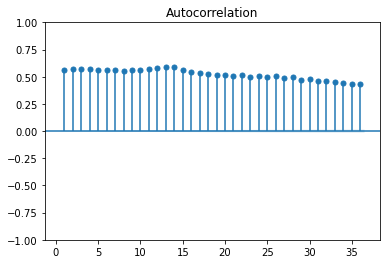

In [13]:
sgt.plot_acf(pm25["original"],lags=36,zero=False);

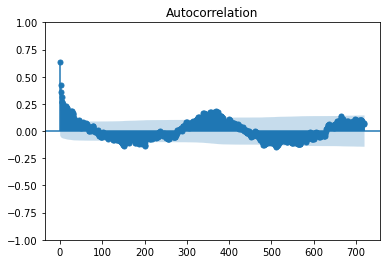

In [14]:
sgt.plot_acf(pm25D["original"],lags=720,zero=False);

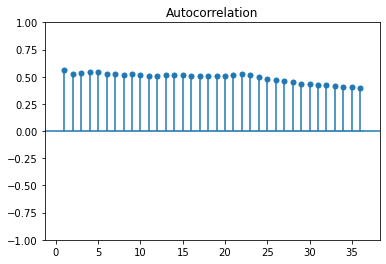

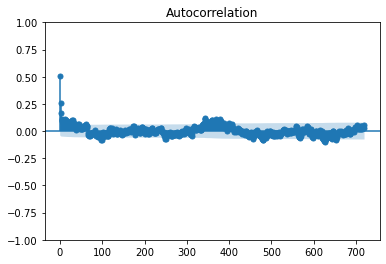

In [22]:
WSP = param(meteo,"WSP")
WSPD = paramD(meteo,"WSP")
sgt.plot_acf(WSP["original"],lags=36,zero=False);
sgt.plot_acf(WSPD["original"],lags=720,zero=False);

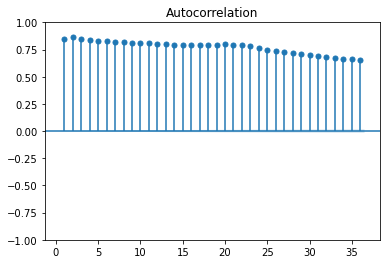

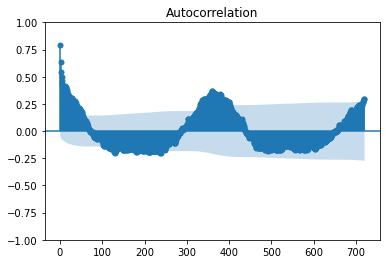

In [23]:
TMP = param(meteo,"TMP")
TMPD = paramD(meteo,"TMP")
sgt.plot_acf(TMP["original"],lags=36,zero=False);
sgt.plot_acf(TMPD["original"],lags=720,zero=False);

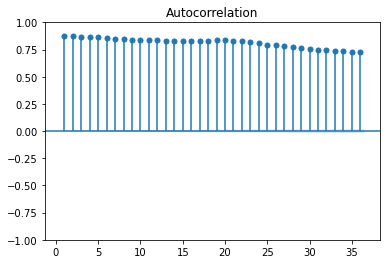

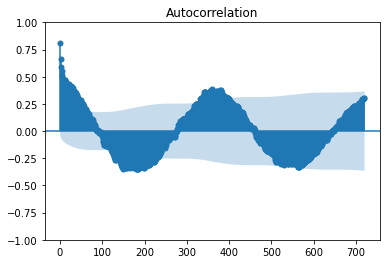

In [4]:
RH = param(meteo,"RH")
RHD = paramD(meteo,"RH")
sgt.plot_acf(RH["original"],lags=36,zero=False);
sgt.plot_acf(RHD["original"],lags=720,zero=False);

## Estacionariedad por cada parámetro

### Contaminantes

In [18]:
P = poll["id_parameter_id"].unique()

for i in P:
    H = param(poll,i)
    D = paramD(poll,i)
    print(i)
    print("\n Por Horas")
    print(f'\n p-value: {sts.adfuller(H["original"],regression="ct",maxlag=16,autolag=None)[1]}\n')
    print("\n Por Días")
    print(f'\n p-value: {sts.adfuller(D["original"],regression="ct",maxlag=365,autolag=None)[1]}\n')

CO

 Por Horas

 p-value: 0.0


 Por Días

 p-value: 0.9014349822279668

O3

 Por Horas

 p-value: 0.0


 Por Días

 p-value: 0.5599111221236808

NOX

 Por Horas

 p-value: 0.0


 Por Días

 p-value: 0.5807027985173216

NO2

 Por Horas

 p-value: 0.0


 Por Días

 p-value: 0.6501479687356309

NO

 Por Horas

 p-value: 0.0


 Por Días

 p-value: 0.5094072889339754

SO2

 Por Horas

 p-value: 0.0


 Por Días

 p-value: 0.6393606263598712

PM2.5

 Por Horas

 p-value: 0.0


 Por Días

 p-value: 0.7403095288418124

PM10

 Por Horas

 p-value: 0.0


 Por Días

 p-value: 0.6935470085748467

PMCO

 Por Horas

 p-value: 0.0


 Por Días

 p-value: 0.43814933535401884



### Meteorológicos

In [20]:
M = meteo["id_parameter_id"].unique()

for i in M:
    H = param(meteo,i)
    D = paramD(meteo,i)
    print(i)
    print("\n Por Horas")
    print(f'\n p-value: {sts.adfuller(H["original"],regression="ct",maxlag=16,autolag=None)[1]}\n')
    print("\n Por Días")
    print(f'\n p-value: {sts.adfuller(D["original"],regression="ct",maxlag=365,autolag=None)[1]}\n')

WSP

 Por Horas

 p-value: 0.0


 Por Días

 p-value: 0.8843063285255724

TMP

 Por Horas

 p-value: 0.0


 Por Días

 p-value: 0.051618856531641145

WDR

 Por Horas

 p-value: 0.0


 Por Días

 p-value: 0.9012467070695038

RH

 Por Horas

 p-value: 0.0


 Por Días

 p-value: 0.06167508186554309



De aquí concluimos que todos lo parámetros de contaminación y meteorológicos promediados por día son **no-estacionarios**

### Diferenciación de series de tiempo

Determinación del parámetro $d$, i.e las veces en las que tenemos que diferenciar la serie de tiempo hasta obtener una serie estacionaria.

In [6]:
M = meteo["id_parameter_id"].unique()
P = poll["id_parameter_id"].unique()

for i in P:
    D = paramD(poll,i)
    print(i)
    print("\n Por Días")
    print(f'\n p-value: {sts.adfuller(D["original"].diff().dropna(),regression="ct",maxlag=365,autolag=None)[1]}\n')
    if D["original"].std() <= D["original"].diff().dropna().std():
        print("\t d=0")
    else:
        print("\t d=1")
for i in M:
    D = paramD(meteo,i)
    print(i)
    print("\n Por Días")
    print(f'\n p-value: {sts.adfuller(D["original"].diff().dropna(),regression="ct",maxlag=365,autolag=None)[1]}\n')
    if D["original"].std() <= D["original"].diff().dropna().std():
        print("\t d=0")
    else:
        print("\t d=1")

CO

 Por Días

 p-value: 0.0011334433241039985

	 d=1
O3

 Por Días

 p-value: 3.0823936947343917e-07

	 d=1
NOX

 Por Días

 p-value: 9.269379122951207e-05

	 d=1
NO2

 Por Días

 p-value: 4.215597245922182e-05

	 d=1
NO

 Por Días

 p-value: 5.727313535343441e-05

	 d=1
SO2

 Por Días

 p-value: 0.0004101176195872086

	 d=0
PM2.5

 Por Días

 p-value: 3.311407012764508e-08

	 d=1
PM10

 Por Días

 p-value: 8.994578558958504e-08

	 d=1
PMCO

 Por Días

 p-value: 8.144996487647423e-06

	 d=1
WSP

 Por Días

 p-value: 4.468038816885119e-07

	 d=1
TMP

 Por Días

 p-value: 2.403953394400312e-11

	 d=1
WDR

 Por Días

 p-value: 4.767822952445063e-06

	 d=0
RH

 Por Días

 p-value: 4.239942216816381e-08

	 d=1


Por lo que:

$$d_{CO}=1,\quad d_{O3}=1,\quad d_{NOX}=1,\quad d_{NO2}=1,\quad d_{NO}=1,\quad d_{SO2}=0,\quad d_{PM2.5}=1,\quad d_{PM10}=1,\quad d_{PMCO}=1$$

$$d_{WSP}=1,\quad d_{TMP}=1,\quad d_{WDR}=0,\quad d_{RH}=1$$

De esta manera, las distintas $d$ que se tomarán para el modelo ARIMA son los enlistadas arriba para cada uno de los parámetros

---

### Determinación del parámetro $p$

Fijándonos en las diferenciaciones de la sección anterior, graficamos la autocorrelación parcial para observar el valor del parámetro $p$

CO


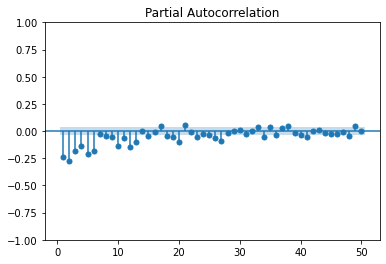

O3


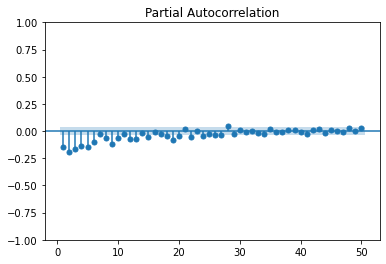

NOX


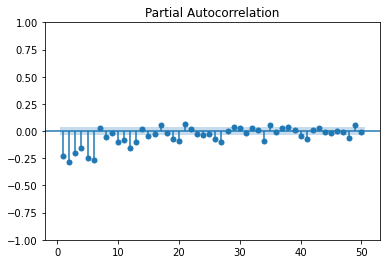

NO2


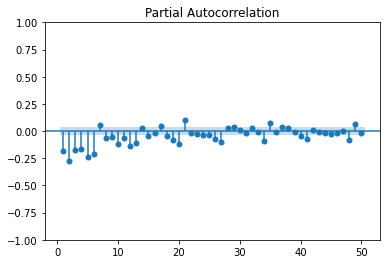

NO


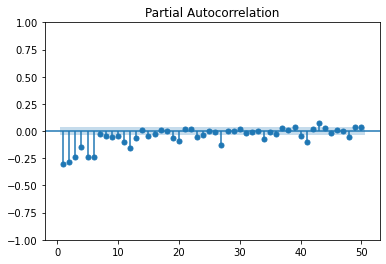

SO2


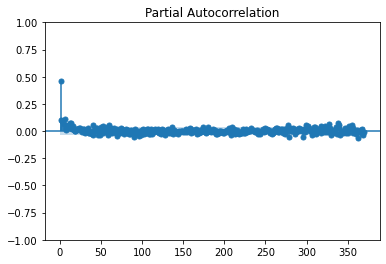

PM2.5


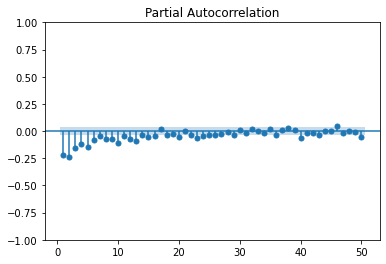

PM10


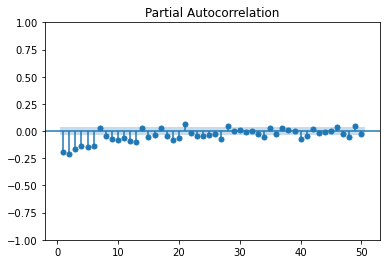

PMCO


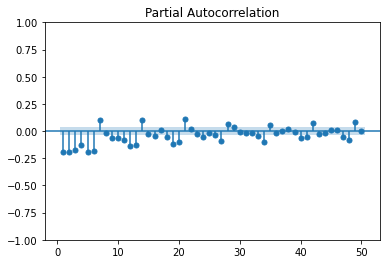

WSP


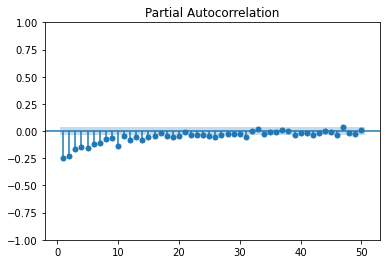

TMP


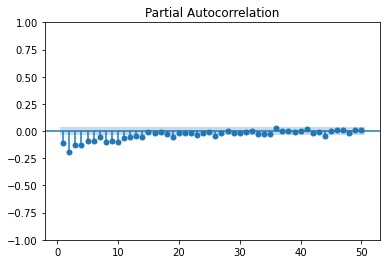

WDR


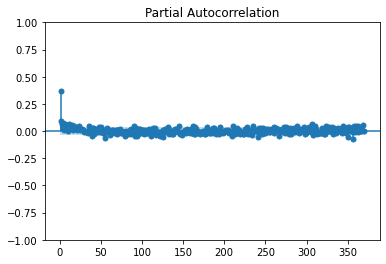

RH


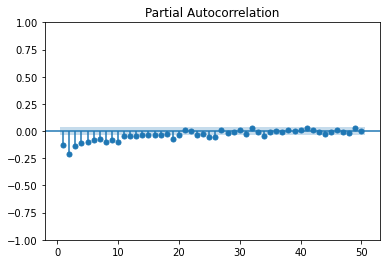

In [11]:
M = meteo["id_parameter_id"].unique()
P = poll["id_parameter_id"].unique()

for i in P:
    D = paramD(poll,i)
    print(i)
    if i != "SO2":
        sgt.plot_pacf(D["original"].diff().dropna(),zero=False,lags=50,method="ols");
        plt.show()
    else:
        sgt.plot_pacf(D["original"],zero=False,lags=370,method="ols");
        plt.show()
        
for i in M:
    D = paramD(meteo,i)
    print(i)
    if i != "WDR":
        sgt.plot_pacf(D["original"].diff().dropna(),zero=False,lags=50,method="ols");
        plt.show()
    else:
        sgt.plot_pacf(D["original"],zero=False,lags=370,method="ols");
        plt.show()

De esta manera:

$$p_{CO}=2,\quad p_{O3}=2,\quad p_{NOX}=2,\quad p_{NO2}=2,\quad p_{NO}=1,\quad p_{SO2}=1,\quad p_{PM2.5}=2,\quad p_{PM10}=2,\quad p_{PMCO}=2$$

$$p_{WSP}=1,\quad p_{TMP}=2,\quad p_{WDR}=1,\quad p_{RH}=2$$

---

In [ ]:
def arima_model(p,d,q,data)

## PM2.5

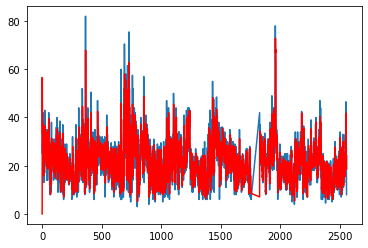

In [4]:
d = 1
p = 2
q = 0

dat=paramD(poll,"PM2.5")["original"]
modelo = ARIMA(dat,order=(p,d,q))
resultados = modelo.fit()
plt.plot(dat)
plt.plot(resultados.fittedvalues,color="red")

In [15]:
print(resultados.summary())

                               SARIMAX Results                                
Dep. Variable:               original   No. Observations:                 2486
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -8534.640
Date:                Fri, 15 Oct 2021   AIC                          17075.279
Time:                        21:25:52   BIC                          17092.733
Sample:                             0   HQIC                         17081.618
                               - 2486                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2737      0.012    -22.342      0.000      -0.298      -0.250
ar.L2         -0.2409      0.016    -15.175      0.000      -0.272      -0.210
sigma2        56.3162      0.929     60.642      0.0

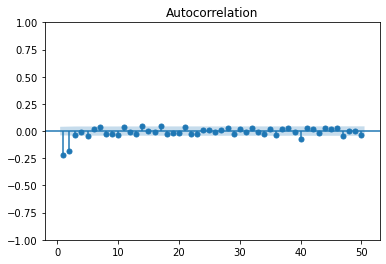

In [7]:
D = paramD(poll,"PM2.5")
sgt.plot_acf(D["original"].diff().dropna(),lags=50,zero=False);

In [6]:
d = 1
p = 2
dat=paramD(poll,"PM2.5")["original"]
for q in range(50):
    modelo = ARIMA(dat,order=(p,d,q))
    resultados = modelo.fit()
    print(f"q = {q}, AIC = {resultados.aic}")

q = 0, AIC = 17075.27902851069
q = 1, AIC = 16791.511290748596
q = 2, AIC = 16790.90156769834
q = 3, AIC = 16793.933914217
q = 4, AIC = 16789.905658446372
q = 5, AIC = 16791.492840453844
q = 6, AIC = 16795.778377772753
q = 7, AIC = 16791.521641698226
q = 8, AIC = 16787.510706035828
q = 9, AIC = 16790.561825154695
q = 10, AIC = 16783.50309997538
q = 11, AIC = 16785.38793290083
q = 12, AIC = 16785.968536340784
q = 13, AIC = 16787.584137664137
q = 14, AIC = 16789.409069361027
q = 15, AIC = 16788.89529653245
q = 16, AIC = 16791.452349886218
q = 17, AIC = 16792.67992857923
q = 18, AIC = 16788.52589877176
q = 19, AIC = 16790.639536509912
q = 20, AIC = 16790.036205227352
q = 21, AIC = 16792.03568277139
q = 22, AIC = 16793.800242629437
q = 23, AIC = 16795.76687780958
q = 24, AIC = 16797.010467600616
q = 25, AIC = 16799.258420118706
q = 26, AIC = 16801.17110068999
q = 27, AIC = 16801.574422138372
q = 28, AIC = 16801.524564285137
q = 29, AIC = 16788.419377704507
q = 30, AIC = 16788.70154572266
q

KeyboardInterrupt: 

                               SARIMAX Results                                
Dep. Variable:               original   No. Observations:                 2486
Model:                ARIMA(2, 1, 10)   Log Likelihood               -8378.752
Date:                Wed, 20 Oct 2021   AIC                          16783.503
Time:                        09:49:52   BIC                          16859.137
Sample:                             0   HQIC                         16810.970
                               - 2486                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8302      0.117     -7.086      0.000      -1.060      -0.601
ar.L2         -0.7320      0.120     -6.077      0.000      -0.968      -0.496
ma.L1          0.4156      0.118      3.530      0.0

<AxesSubplot:title={'center':'Densidad'}, ylabel='Density'>

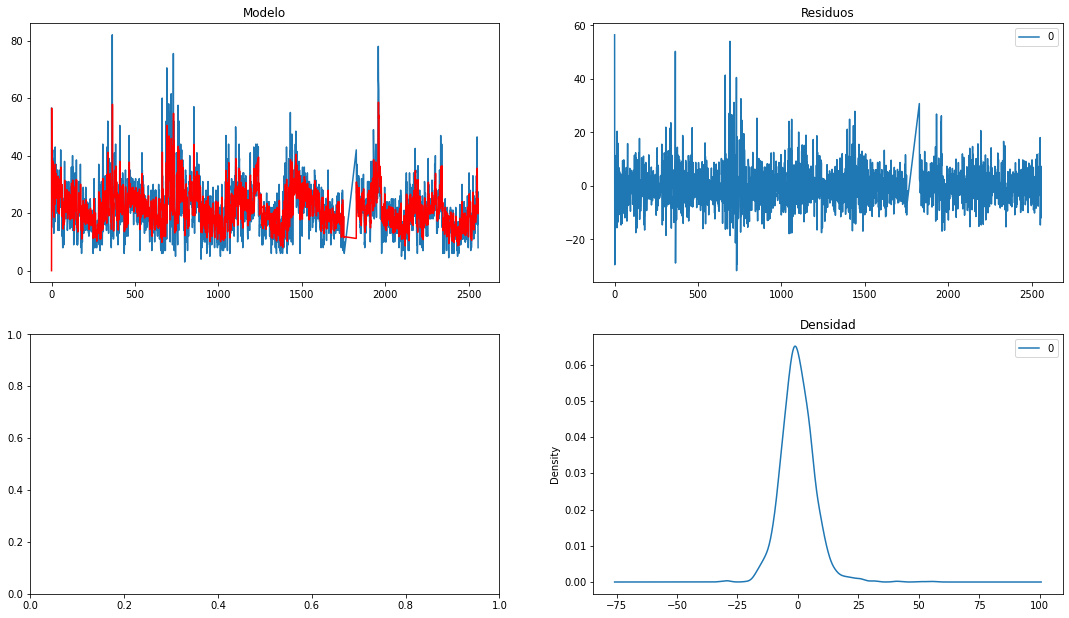

In [4]:
d = 1
p = 2
q = 10
dat=paramD(poll,"PM2.5")["original"]
modelo = ARIMA(dat,order=(p,d,q))
resultados = modelo.fit()
residuals = pd.DataFrame(resultados.resid)
print(resultados.summary())

fig,ax = plt.subplots(2,2)
fig.set_size_inches(18.5, 10.5)
dat.plot(ax=ax[0,0])
resultados.fittedvalues.plot(title="Modelo",color="red",ax=ax[0,0])
residuals.plot(title="Residuos",ax=ax[0,1])
residuals.plot(kind="kde",title="Densidad",ax=ax[1,1])

In [16]:
result = sts.adfuller(residuals,regression="ct",maxlag=365,autolag=None)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -5.628637925835771
p-value: 1.2765717995185495e-05
Critial Values:
   1%, -3.963046669473269
Critial Values:
   5%, -3.412562958660295
Critial Values:
   10%, -3.128270498299351


De esta manera los residuos de nuestro modelo se comporta como **ruido blanco** i.e como una serie estacionaria, por el resultado que tuvimos con el p-valor y en su distribución centrada.

Si nos interesamos en le estacionalidad, i.e utilizar el modelo de SARIMA, observamos que tanto el AIC como el Log Likelyhod toman valores similares (Al menos para PM2.5) y podemos concluir que con el modelo ARIMA basta para el análisis de las series de tiempo

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.37106D+00    |proj g|=  1.26888D-02

At iterate    5    f=  3.37076D+00    |proj g|=  2.37818D-03

At iterate   10    f=  3.37068D+00    |proj g|=  1.44578D-03

At iterate   15    f=  3.37054D+00    |proj g|=  1.83121D-03

At iterate   20    f=  3.37048D+00    |proj g|=  1.28515D-03

At iterate   25    f=  3.37046D+00    |proj g|=  1.76270D-03

At iterate   30    f=  3.37037D+00    |proj g|=  5.56821D-03

At iterate   35    f=  3.37036D+00    |proj g|=  3.73546D-04

At iterate   40    f=  3.37036D+00    |proj g|=  6.04985D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final

<AxesSubplot:title={'center':'Densidad'}, ylabel='Density'>

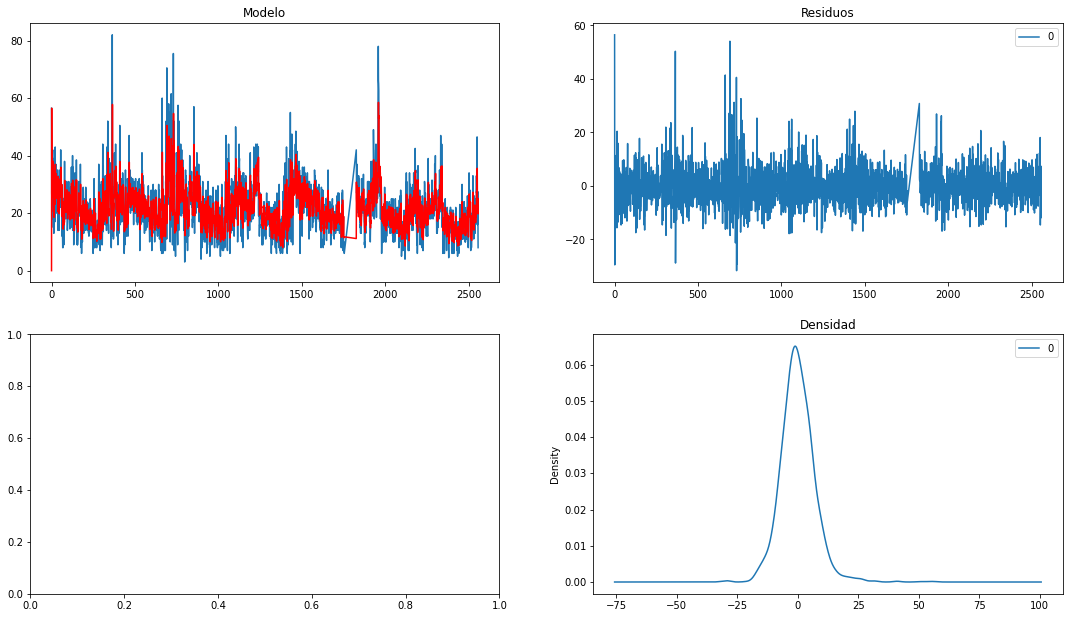

In [5]:
d = 1
p = 2
q = 10
dat=paramD(poll,"PM2.5")["original"]
modelo = sm.tsa.statespace.SARIMAX(dat, order=(p,d,q), trend="c")
resultados = modelo.fit()
residuals = pd.DataFrame(resultados.resid)
print(resultados.summary())

fig,ax = plt.subplots(2,2)
fig.set_size_inches(18.5, 10.5)
dat.plot(ax=ax[0,0])
resultados.fittedvalues.plot(title="Modelo",color="red",ax=ax[0,0])
residuals.plot(title="Residuos",ax=ax[0,1])
residuals.plot(kind="kde",title="Densidad",ax=ax[1,1])

## PM10

In [24]:
d = 1
p = 2
dat=paramD(poll,"PM10")["original"]
for q in range(20):
    modelo = ARIMA(dat,order=(p,d,q))
    resultados = modelo.fit()
    print(f"q = {q}, AIC = {resultados.aic}")

q = 0, AIC = 19110.016491928927
q = 1, AIC = 18835.4221655331
q = 2, AIC = 18836.561661958396
q = 3, AIC = 18837.15388912469
q = 4, AIC = 18839.14451816061
q = 5, AIC = 18830.678373906492
q = 6, AIC = 18778.824849177698
q = 7, AIC = 18773.38570269307
q = 8, AIC = 18806.675591687617
q = 9, AIC = 18804.595299453824
q = 10, AIC = 18803.514180136273
q = 11, AIC = 18804.134908547054
q = 12, AIC = 18804.601140249935
q = 13, AIC = 18761.03322747638
q = 14, AIC = 18760.043238128324
q = 15, AIC = 18759.934590875324
q = 16, AIC = 18756.903261907803
q = 17, AIC = 18752.948678726105
q = 18, AIC = 18787.20960766748
q = 19, AIC = 18771.515311724244


                               SARIMAX Results                                
Dep. Variable:               original   No. Observations:                 2486
Model:                ARIMA(2, 1, 17)   Log Likelihood               -9356.474
Date:                Wed, 20 Oct 2021   AIC                          18752.949
Time:                        10:10:04   BIC                          18869.309
Sample:                             0   HQIC                         18795.206
                               - 2486                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4440      0.002   -189.687      0.000      -0.449      -0.439
ar.L2         -0.9954      0.002   -421.407      0.000      -1.000      -0.991
ma.L1          0.0987      0.016      6.145      0.0

<AxesSubplot:title={'center':'Densidad'}, ylabel='Density'>

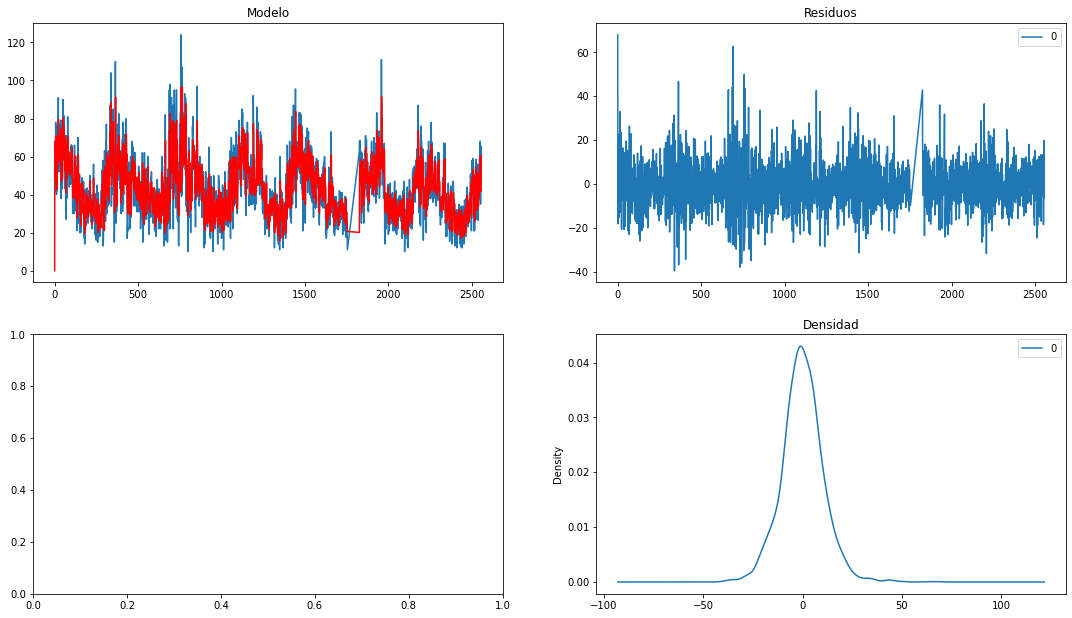

In [7]:
d = 1
p = 2
q = 17

dat=paramD(poll,"PM10")["original"]
modelo = ARIMA(dat,order=(p,d,q))
resultados = modelo.fit()
residuals = pd.DataFrame(resultados.resid)
print(resultados.summary())

fig,ax = plt.subplots(2,2)
fig.set_size_inches(18.5, 10.5)
dat.plot(ax=ax[0,0])
resultados.fittedvalues.plot(title="Modelo",color="red",ax=ax[0,0])
residuals.plot(title="Residuos",ax=ax[0,1])
residuals.plot(kind="kde",title="Densidad",ax=ax[1,1])

In [33]:
result = sts.adfuller(residuals,regression="ct",maxlag=365,autolag=None)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -5.858298961475778
p-value: 4.338344121452673e-06
Critial Values:
   1%, -3.963046669473269
Critial Values:
   5%, -3.412562958660295
Critial Values:
   10%, -3.128270498299351


De esta manera los residuos de nuestro modelo se comporta como **ruido blanco** i.e como una serie estacionaria, por el resultado que tuvimos con el p-valor y en su distribución centrada.

Ahora si consideramos estacionalidad más aparte variables exógenas que sabemos que dependen de nuestro parámetro `PM10` por el `analysis5.ipynb`. Sin embargo al poner el modelo SARIMAX con las variables exógenas observamos que el AIC y el log likelyhod no cambian tanto a comparación del modelo ARIMA.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77462D+00    |proj g|=  2.17668D-02

At iterate    5    f=  3.77350D+00    |proj g|=  3.73463D-03

At iterate   10    f=  3.77314D+00    |proj g|=  6.46051D-03

At iterate   15    f=  3.77183D+00    |proj g|=  2.15493D-02

At iterate   20    f=  3.77071D+00    |proj g|=  4.95994D-03

At iterate   25    f=  3.76915D+00    |proj g|=  4.76429D-02

At iterate   30    f=  3.76826D+00    |proj g|=  1.83774D-02

At iterate   35    f=  3.76628D+00    |proj g|=  8.04910D-02

At iterate   40    f=  3.76504D+00    |proj g|=  8.73244D-03

At iterate   45    f=  3.76429D+00    |proj g|=  5.14245D-02

At iterate   50    f=  3.76415D+00    |proj g|=  1.80457D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number

<AxesSubplot:title={'center':'Densidad'}, ylabel='Density'>

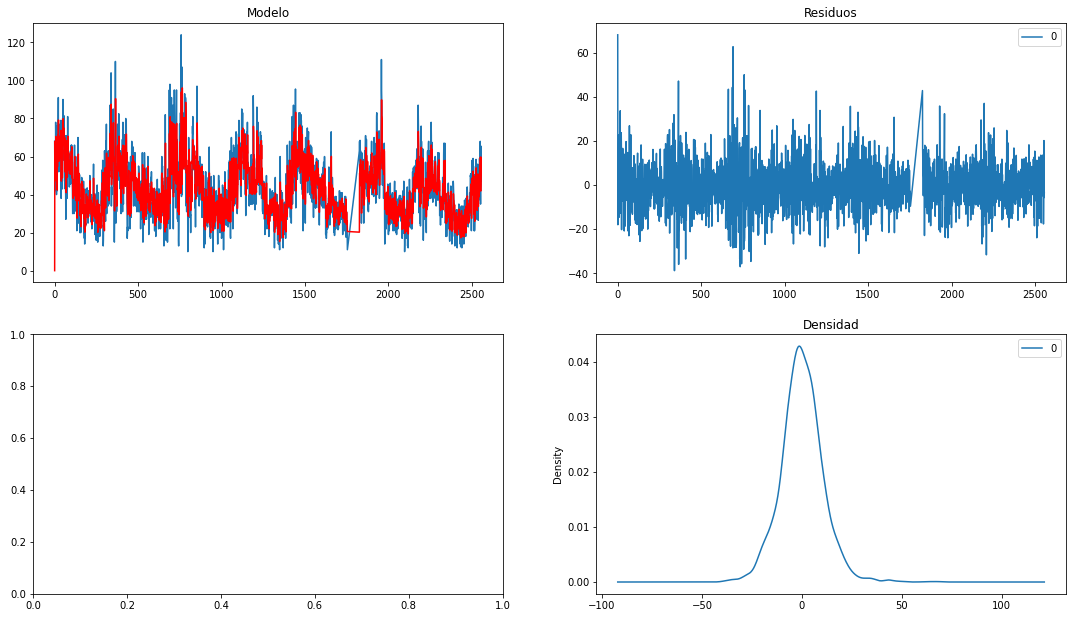

In [8]:
d = 1
p = 2
q = 17
dat=paramD(poll,"PM10")["original"]
modelo = sm.tsa.statespace.SARIMAX(dat, order=(p,d,q), trend="c", exogenous=np.array([np.sqrt(paramD(poll,"NO")["original"]), np.sqrt(paramD(meteo,"RH")["original"])/10]))
resultados = modelo.fit()
residuals = pd.DataFrame(resultados.resid)
print(resultados.summary())

fig,ax = plt.subplots(2,2)
fig.set_size_inches(18.5, 10.5)
dat.plot(ax=ax[0,0])
resultados.fittedvalues.plot(title="Modelo",color="red",ax=ax[0,0])
residuals.plot(title="Residuos",ax=ax[0,1])
residuals.plot(kind="kde",title="Densidad",ax=ax[1,1])

## O3

In [5]:
d = 1
p = 2
dat=paramD(poll,"O3")["original"]
for q in range(20):
    modelo = ARIMA(dat,order=(p,d,q))
    resultados = modelo.fit()
    print(f"q = {q}, AIC = {resultados.aic}")

q = 0, AIC = 17464.425945989547
q = 1, AIC = 17185.45809027874
q = 2, AIC = 17187.430252713486
q = 3, AIC = 17189.192641885846
q = 4, AIC = 17191.206362299723
q = 5, AIC = 17183.338601480318
q = 6, AIC = 17173.890376867163
q = 7, AIC = 17170.368255566184
q = 8, AIC = 17172.389973652767
q = 9, AIC = 17179.302605288067
q = 10, AIC = 17177.95175260791
q = 11, AIC = 17179.705057105326
q = 12, AIC = 17181.69908679177
q = 13, AIC = 17183.24568366892
q = 14, AIC = 17185.167856445412
q = 15, AIC = 17187.162875287086
q = 16, AIC = 17188.381169013137
q = 17, AIC = 17190.642547293948
q = 18, AIC = 17181.805869103337
q = 19, AIC = 17179.992839177918


<AxesSubplot:title={'center':'Densidad'}, ylabel='Density'>

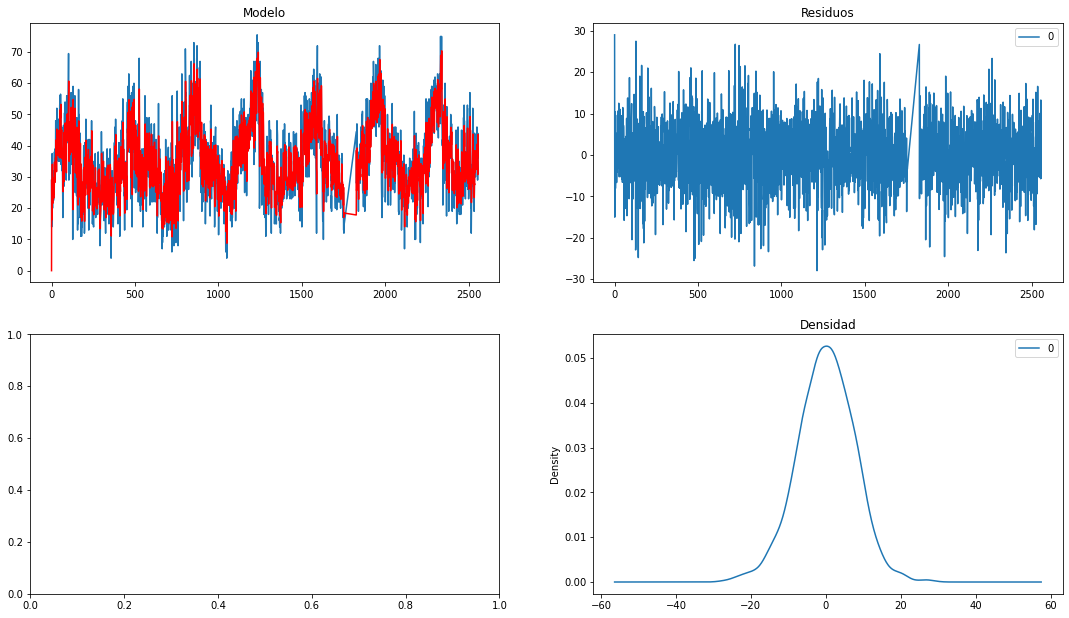

In [6]:
d = 1
p = 2
q = 7

dat=paramD(poll,"O3")["original"]
modelo = ARIMA(dat,order=(p,d,q))
resultados = modelo.fit()
residuals = pd.DataFrame(resultados.resid)

fig,ax = plt.subplots(2,2)
fig.set_size_inches(18.5, 10.5)
dat.plot(ax=ax[0,0])
resultados.fittedvalues.plot(title="Modelo",color="red",ax=ax[0,0])
residuals.plot(title="Residuos",ax=ax[0,1])
residuals.plot(kind="kde",title="Densidad",ax=ax[1,1])

In [7]:
result = sts.adfuller(residuals,regression="ct",maxlag=365,autolag=None)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -5.680906360770354
p-value: 1.0012496806045728e-05
Critial Values:
   1%, -3.963046669473269
Critial Values:
   5%, -3.412562958660295
Critial Values:
   10%, -3.128270498299351


De esta manera los residuos de nuestro modelo se comporta como **ruido blanco** i.e como una serie estacionaria, por el resultado que tuvimos con el p-valor y en su distribución centrada.

## NO2

In [10]:
d = 1
p = 2
dat=paramD(poll,"NO2")["original"]
for q in range(50):
    modelo = ARIMA(dat,order=(p,d,q))
    resultados = modelo.fit()
    print(f"q = {q}, AIC = {resultados.aic}")

q = 0, AIC = 15661.337122638815
q = 1, AIC = 15251.938701095889
q = 2, AIC = 15258.808591111136
q = 3, AIC = 15255.556581251527
q = 4, AIC = 15257.555607012979
q = 5, AIC = 15116.103863799104
q = 6, AIC = 15210.871276732036
q = 7, AIC = 15187.6545962705
q = 8, AIC = 15171.367452379569
q = 9, AIC = 15114.05867975884
q = 10, AIC = 15157.316095213107
q = 11, AIC = 15160.002070893905
q = 12, AIC = 15162.347187018207
q = 13, AIC = 15085.863611263107
q = 14, AIC = 15079.044171999467
q = 15, AIC = 15079.550629788975
q = 16, AIC = 15086.322810239191
q = 17, AIC = 15080.527718903266
q = 18, AIC = 15115.590301846765
q = 19, AIC = 15101.821003301962
q = 20, AIC = 15106.100710821085
q = 21, AIC = 15066.78514338415
q = 22, AIC = 15097.915154275252
q = 23, AIC = 15097.025568219466
q = 24, AIC = 15059.405082215922
q = 25, AIC = 15065.656372058169
q = 26, AIC = 15070.716914033557
q = 27, AIC = 15088.336291296644
q = 28, AIC = 15089.478466351573
q = 29, AIC = 15075.280929174667
q = 30, AIC = 15077.4060

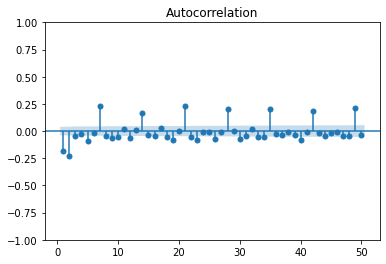

In [22]:
D = paramD(poll,"NO2")
sgt.plot_acf(D["original"].diff().dropna(),lags=50,zero=False);

<AxesSubplot:title={'center':'Densidad'}, ylabel='Density'>

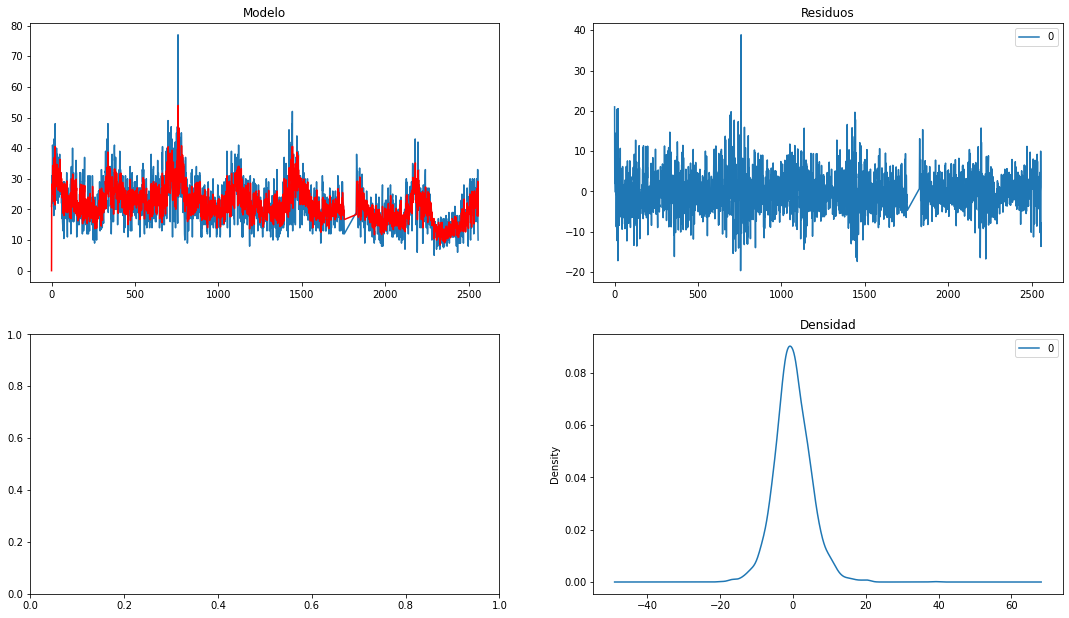

In [23]:
d = 1
p = 2
q = 21

dat=paramD(poll,"NO2")["original"]
modelo = ARIMA(dat,order=(p,d,q))
resultados = modelo.fit()
residuals = pd.DataFrame(resultados.resid)

fig,ax = plt.subplots(2,2)
fig.set_size_inches(18.5, 10.5)
dat.plot(ax=ax[0,0])
resultados.fittedvalues.plot(title="Modelo",color="red",ax=ax[0,0])
residuals.plot(title="Residuos",ax=ax[0,1])
residuals.plot(kind="kde",title="Densidad",ax=ax[1,1])

In [24]:
result = sts.adfuller(residuals,regression="ct",maxlag=365,autolag=None)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.8286742064632584
p-value: 0.015164169621101613
Critial Values:
   1%, -3.963046669473269
Critial Values:
   5%, -3.412562958660295
Critial Values:
   10%, -3.128270498299351


## CO

In [29]:
d = 1
p = 2
dat=paramD(poll,"CO")["original"]
for q in range(50):
    modelo = ARIMA(dat,order=(p,d,q))
    resultados = modelo.fit()
    print(f"q = {q}, AIC = {resultados.aic}")

q = 0, AIC = -2946.033605395407
q = 1, AIC = -3363.6577052186803
q = 2, AIC = -3362.700835179666
q = 3, AIC = -3360.9873711117107
q = 4, AIC = -3376.3695837176833
q = 5, AIC = -3387.7177522330508
q = 6, AIC = -3389.7693342691136
q = 7, AIC = -3389.437464528038
q = 8, AIC = -3393.206611977371
q = 9, AIC = -3397.2929683442976
q = 10, AIC = -3407.84642426151
q = 11, AIC = -3409.481445833436
q = 12, AIC = -3407.805990081331
q = 13, AIC = -3414.874437225488
q = 14, AIC = -3411.898553595556
q = 15, AIC = -3413.493069069946
q = 16, AIC = -3414.3223560810725
q = 17, AIC = -3419.533855380935
q = 18, AIC = -3438.7620706564007
q = 19, AIC = -3439.2936702181914
q = 20, AIC = -3437.487618645906
q = 21, AIC = -3445.700351337903
q = 22, AIC = -3446.121160467307
q = 23, AIC = -3436.6645003545113
q = 24, AIC = -3443.2974899124943
q = 25, AIC = -3436.9299329469313
q = 26, AIC = -3435.9926919404015
q = 27, AIC = -3453.21039950223
q = 28, AIC = -3451.7495752981795
q = 29, AIC = -3459.7407682440735
q = 30,

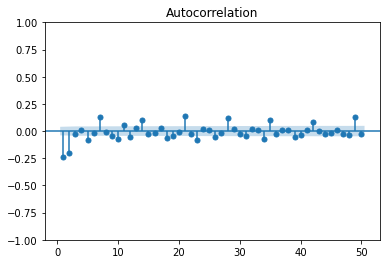

In [26]:
D = paramD(poll,"CO")
sgt.plot_acf(D["original"].diff().dropna(),lags=50,zero=False);

<AxesSubplot:title={'center':'Densidad'}, ylabel='Density'>

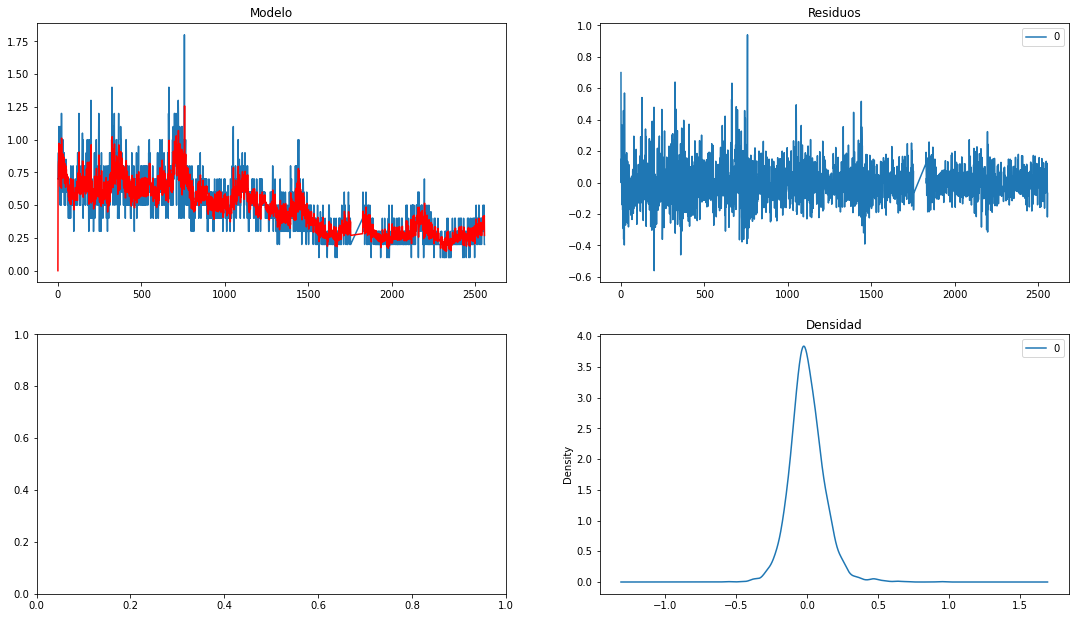

In [27]:
d = 1
p = 2
q = 1

dat=paramD(poll,"CO")["original"]
modelo = ARIMA(dat,order=(p,d,q))
resultados = modelo.fit()
residuals = pd.DataFrame(resultados.resid)

fig,ax = plt.subplots(2,2)
fig.set_size_inches(18.5, 10.5)
dat.plot(ax=ax[0,0])
resultados.fittedvalues.plot(title="Modelo",color="red",ax=ax[0,0])
residuals.plot(title="Residuos",ax=ax[0,1])
residuals.plot(kind="kde",title="Densidad",ax=ax[1,1])

In [28]:
result = sts.adfuller(residuals,regression="ct",maxlag=365,autolag=None)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.2451309766267253
p-value: 0.07577804923236545
Critial Values:
   1%, -3.963046669473269
Critial Values:
   5%, -3.412562958660295
Critial Values:
   10%, -3.128270498299351


Aquí pasa algo raro :$

---

Suponiendo una propiedad aditiva entre $T$ la tendencia, $S$ estacionalidad, $C$ ciclicidad, $N$ ruido como:

$$y_t = T_t+S_t+C_t+N_t$$

## Estacionalidad

Aún no termino :(

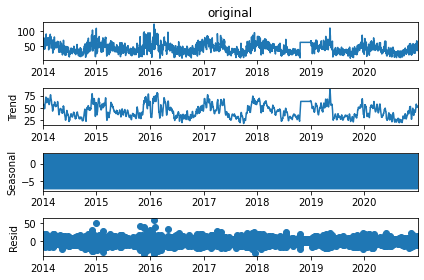

In [33]:
dcm_ad = seasonal_decompose(pm10D["original"].asfreq("d").fillna(method='bfill'),model="additive")
dcm_ad.plot();

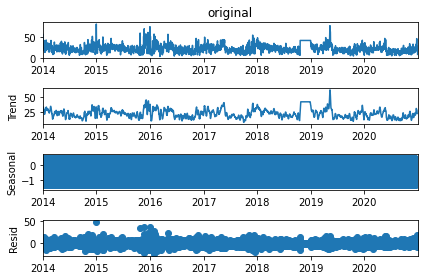

In [34]:
dcm_ad = seasonal_decompose(pm25D["original"].asfreq("d").fillna(method='bfill'),model="additive")
dcm_ad.plot();

In [31]:
pm25D.set_index("dateUTCShiftedDown",inplace=True)

In [25]:
pm10D.asfreq("d")

,original
dateUTCShiftedDown,
2014-01-01,68.0
2014-01-02,50.0
2014-01-03,42.0
2014-01-04,48.5
2014-01-05,52.5
...,...
2020-12-27,35.0
2020-12-28,45.0
2020-12-29,65.5
